In [1]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

from tqdm import tqdm_notebook


# Saving models
import pickle

In [45]:
data=pd.read_csv("covid19_tweets.csv")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

In [4]:
data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [5]:
#data['source'].unique().size
data['user_location'].unique().size

26921

In [6]:
data.shape

(179108, 13)

In [7]:
data.isnull().sum()

user_name               0
user_location       36771
user_description    10286
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            51334
source                 77
is_retweet              0
dtype: int64

In [8]:
def missing_value_of_data(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
missing_value_of_data(data)

,Total,Percentage
hashtags,51334,28.66
user_location,36771,20.53
user_description,10286,5.74
source,77,0.04
is_retweet,0,0.00
text,0,0.00
date,0,0.00
user_verified,0,0.00
user_favourites,0,0.00
user_friends,0,0.00


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


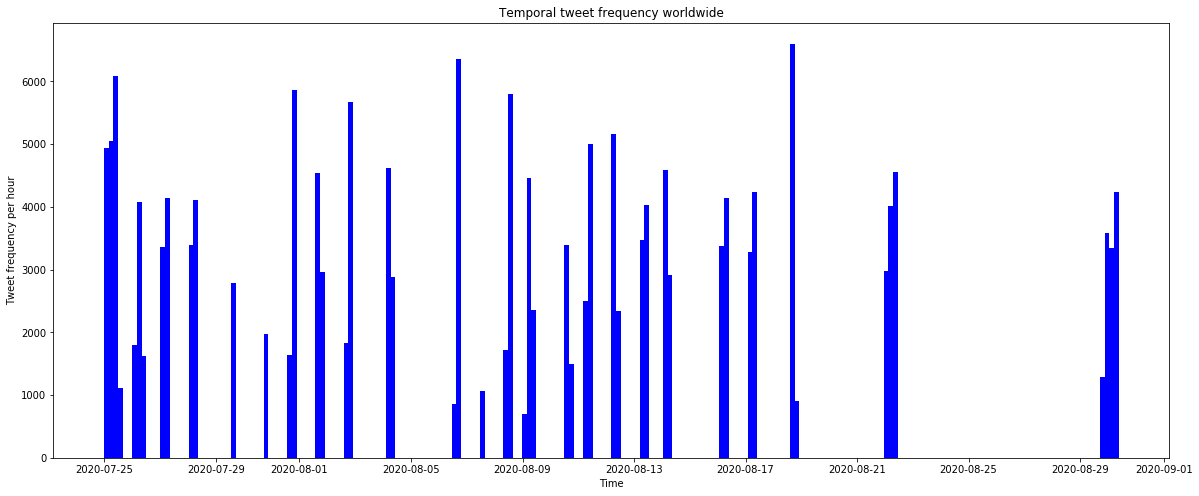

In [10]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(data.date), bins = 24*9, color = 'b')
plt.show()

## Tweet Column

In [11]:
#Picking out the tweet texts
text_en = data['text']

In [12]:
text_en.head()

0    If I smelled the scent of hand sanitizers toda...
1    Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2    @diane3443 @wdunlap @realDonaldTrump Trump nev...
3    @brookbanktv The one gift #COVID19 has give me...
4    25 July : Media Bulletin on Novel #CoronaVirus...
Name: text, dtype: object

In [13]:
#Removing URLs from tweets
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.head()

0    If I smelled the scent of hand sanitizers toda...
1    Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2    @diane3443 @wdunlap @realDonaldTrump Trump nev...
3    @brookbanktv The one gift #COVID19 has give me...
4    25 July : Media Bulletin on Novel #CoronaVirus...
Name: text, dtype: object

In [14]:
text_en_lr[10]

'49K+ Covid19 cases still no response from \n@cbseindia29 @HRDMinistry @DrRPNishank.Please cancel the compartment exa… '

In [15]:
#Converting all tweets to lowercase
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    if i smelled the scent of hand sanitizers toda...
1    hey @yankees @yankeespr and @mlb - wouldn't it...
2    @diane3443 @wdunlap @realdonaldtrump trump nev...
3    @brookbanktv the one gift #covid19 has give me...
4    25 july : media bulletin on novel #coronavirus...
Name: text, dtype: object

In [16]:
#Removing punctuations
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

0    if i smelled the scent of hand sanitizers toda...
1    hey yankees yankeespr and mlb  wouldnt it have...
2    diane3443 wdunlap realdonaldtrump trump never ...
3    brookbanktv the one gift covid19 has give me i...
4    25 july  media bulletin on novel coronavirusup...
Name: text, dtype: object

In [17]:
#Removing stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19','covid-19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0    smelled scent hand sanitizers today someone pa...
1    hey yankees yankeespr mlb wouldnt made sense p...
2    diane3443 wdunlap realdonaldtrump trump never ...
3    brookbanktv one gift give appreciation simple ...
4    25 july media bulletin novel coronavirusupdate...
Name: text, dtype: object

In [18]:
#Concatenating all the tweets into a list of words
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

['smelled', 'scent', 'hand', 'sanitizers', 'today']

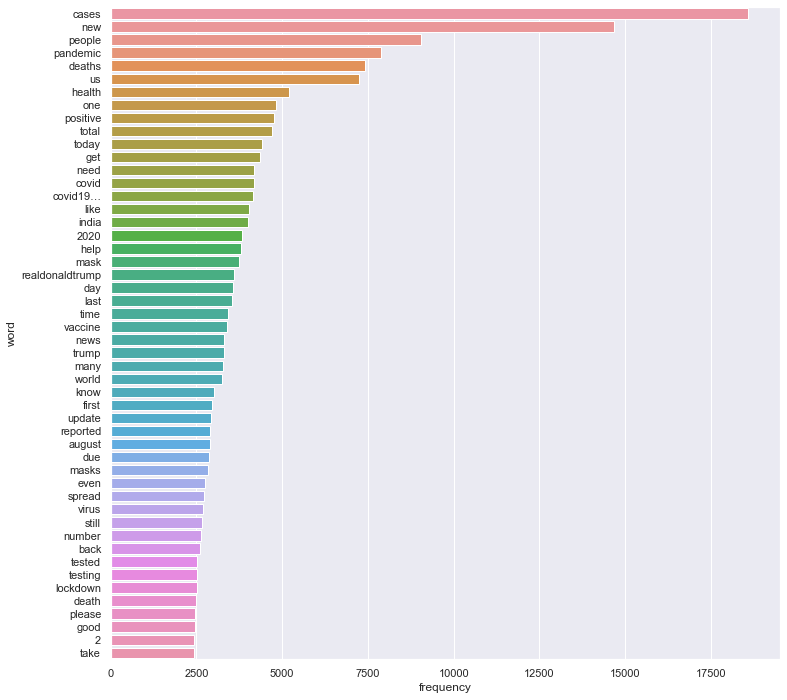

In [19]:
#Calculating the Term Frequency
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')

In [20]:
"""from wordcloud import WordCloud
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')"""

'from wordcloud import WordCloud\nwordcloud = WordCloud(\n    background_color=\'black\',\n    max_words=50,\n    max_font_size=40, \n    scale=5,\n    random_state=1,\n    collocations=False,\n    normalize_plurals=False\n).generate(\' \'.join(word_list))\n\n\nplt.figure(figsize = (12, 10), facecolor = None)\nplt.imshow(wordcloud)\nplt.axis("off")\nplt.tight_layout(pad = 0)\n\nplt.savefig(\'wordcloud.png\')'

### Sentiment Analysis

In [21]:
#Getting the polarity scores for each tweet
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()

,neg,neu,pos,compound
179103,0.000,0.588,0.412,0.4939
179104,0.435,0.235,0.329,-0.2263
179105,0.234,0.584,0.182,-0.2023
179106,0.000,0.660,0.340,0.5574
179107,0.355,0.645,0.000,-0.5267


In [22]:
#Classifying the scores based on the compount polarity value
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

,neg,neu,pos,compound,val
0,0.00,0.758,0.242,0.4939,positive
1,0.11,0.709,0.181,0.2263,positive
2,0.00,0.832,0.168,0.2057,positive
3,0.00,0.563,0.437,0.7351,positive
4,0.00,0.796,0.204,0.3182,positive


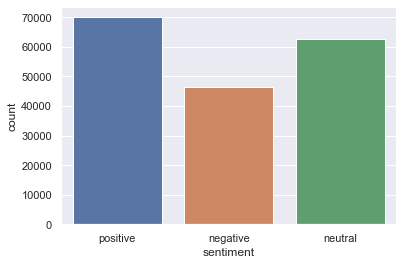

In [23]:
#Plotting the sentiment score counts
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']
sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')

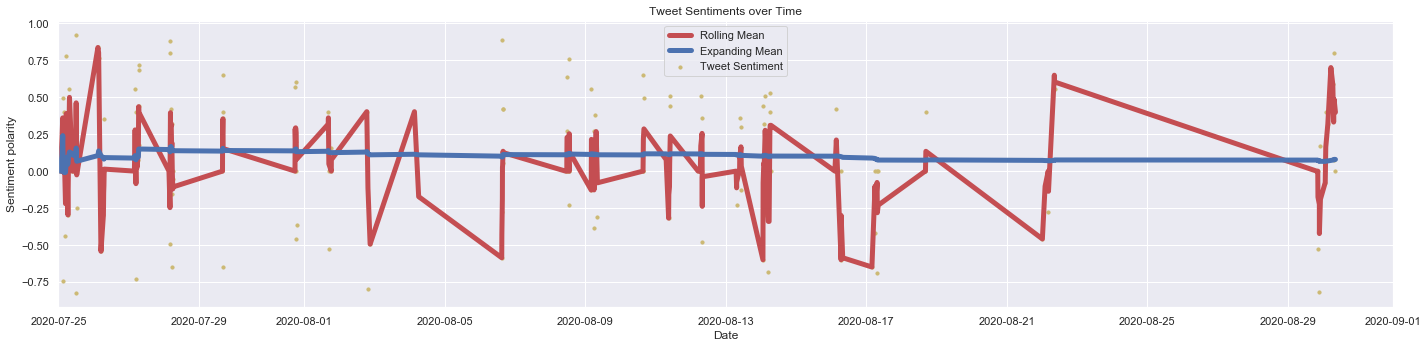

In [24]:
#Temporal plot of the sentiments
sentiments_time_df = pd.DataFrame()
sentiments_time_df['time'] = data['date']
sentiments_time_df['polarity'] = sent_scores_df['compound']
sentiments_time_df.index = pd.to_datetime(sentiments_time_df['time'])

ot = sentiments_time_df.sample(frac=.001)
ot['time'] = pd.to_datetime(ot['time'])
ot.index = pd.to_datetime(ot['time'])
ot.sort_index(inplace=True)
ot['expanding'] = ot['polarity'].expanding().mean()
ot['rolling'] = ot['polarity'].rolling('1h').mean()

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(ot['time'],ot['polarity'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['time'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['time'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,7,25),dt.date(2020,9,1)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.savefig('temporal_sentiments.png')

## Hashtags Columns

In [47]:
data["hashtags_len"]=data.loc[data["hashtags"].notnull(),"hashtags"].apply(lambda x : len(x))

In [48]:
#columns contains list and having missing values will be replaced with empty lists
#data["hashtags"] = data["hashtags"].apply(lambda d: d if isinstance(d, list) else [])

In [49]:
data["hashtags_len"]=data["hashtags_len"].fillna(0)

In [50]:
data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hashtags_len
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,0.0
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0.0
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,11.0
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,11.0
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,33.0


In [109]:
data['hashtags']=data['hashtags']
type(data['hashtags'][0])

float

In [110]:
data['a']=data['hashtags'].values.tolist()

In [111]:
data["a"] = data["a"].apply(lambda d: d if d!='NaN' list(d))

SyntaxError: invalid syntax (<ipython-input-111-2b0ac1d0dd23>, line 1)

In [129]:
for i in range(len(data['a'])):
    if data['a'][i]!='nan':
        print(data['a'][i])

nan
nan
['COVID19']
['COVID19']
['CoronaVirusUpdates', 'COVID19']
['coronavirus', 'covid19']
['COVID19', 'Recruiting']
nan
['covid19', 'covidPositive']
['HurricaneHanna', 'COVID19']
nan
['logo', 'graphicdesigner', 'logodesign', 'logodesinger', 'icon', 'minimalist', 'Abstract']
['COVID19']
['COVID19']
nan
['Covid19', 'keepsocialdistance']
['COVID19', 'TamilNadu', 'chennai']
['COVID19', 'homework']
['light']
nan
nan
nan
nan
['WASH', 'COVID19']
['COVID19']
['Kolar', 'Blood', 'COVID19']
['BosniaandHerzegovina']
['COVID19']
['TNCoronaUpdate', 'TN', 'COVID19']
nan
['FEMA', 'PuertoRico', 'COVID19']
['Covid19', 'Vishal']
['covid19', 'Africa']
['COVID19']
nan
nan
['COVID19']
['COVID19', 'climate']
['BorisJohnson', '5COBRA', 'Five']
['COVID19']
['PlayYourPart', 'COVID19']
['Covid19']
['COVID19']
['Delhi', 'COVID19']
nan
['TamilNadu', 'COVID19']
['RutoSwindlingGEMA', 'COVID19']
nan
nan
['TamilNadu', 'COVID19']
nan
nan
nan
nan
nan
nan
['COVID19']
['covid19']
['COVID19']
['CoronaVirus']
['IndiaFigh

['inspirational', 'motivation', 'COVID19', 'Telangana', 'AndhraPradesh', 'India']
['COVID19']
['COVID19', 'Taiwan']
['Opinion', 'Covid19', 'DirectorGeneralofGhanaEducationService']
['Coronavirus', 'Covid19']
['COVID19']
['COVID19']
['COVID19', 'Business']
nan
['Handwashing', 'WearAMask', 'Socialdistancing']
['COVID19']
nan
['COVID19']
nan
['COVID19']
['RihannaXTiwa', 'alreadyvideo', 'TachaDanceChallange', 'هيون_الغماس', 'BBNaijia2020', 'bbnaija']
['Covid19', 'Vishal']
nan
['SARSCoV2', 'COVID19']
['COVID19']
nan
nan
['COVID19']
['COVID19']
['COVID19']
['Election2020', 'politics']
['Resist', 'COVID19']
['WearAMask', 'COVID19', 'coronavirus', 'Mask']
['COVID19', 'Poland']
['COVID19']
['COVID19']
nan
['DJSBU', 'COVID19']
['COVID19']
nan
nan
['COVID19', 'SRH']
['COVID19', 'GOC', 'coronavirus']
nan
['COVID19', 'CV19']
['COVID19']
['FireHanke', 'Sledgehammer']
['toxic', 'COVID19', 'COVID__19', 'CoronavirusPandemic', 'Lockdown2', 'pandemic']
nan
['Hope', 'USA', 'CorononavirusOutbreak', 'DrBirx

['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']
['COVID19']
['food', 'US', 'meals']
nan
nan
nan
['COVID19']
nan
nan
['remotejobs', 'covid19', 'layoffs', 'Jobs']
['COVID19']
['coronavirus']
['walmart', 'COVID19']
nan
['OkTraitor', 'TrumpIsKillingUs', 'CoronavirusPandemic']
['facemask', 'facemask', 'covid19', 'covid']
nan
['SCOTUS']
['Ferguson']
['PunjabPolice', 'CyberCrimeCell', 'COVID19', 'phishing', 'fraud']
['Hyderabad', 'coronavirus', 'TelanganaFightsCorona']
['PPP']
['Facemask', 'workouts', 'gym', 'fitness', 'Epidemiology']
nan
['GOP', 'Trump', 'COVID19']
['COVID19']
['GOP', 'COVID19']
nan
['coronavirus', 'COVID19']
['COVID19', 'coronavirus']
['ObasekiFlagsOffToday', 'AwayByRemi', 'BuhariWhereIsPIB', 'COVID19']
['COVID19']
['KENYA', 'COVID19']
['COVID19', 'Extremism']
nan
nan
nan
['health', 'healthylifestyle']
['COVID19']
['COVID19', 'ProtectSuffolk', 'ProtectNorfolk']
nan
['herdimmunity']
['COVID19', 'Coronavirus', 'COVID']
nan
nan
['Covid19']
['pandemic', '

['NHS', 'HappyWifeHappyLife', 'COVID19', 'KeyWorkers', 'Thankful']
nan
['CoronaBaba', 'Hyderabad', 'COVID19']
['COVID19']
nan
nan
['BREAKING', 'Kuwait', 'COVID19']
['covid19']
['COVID19']
['AlSadd', 'Barcelona', 'Xavi', 'Covid19', 'Qatar2022', 'QSL']
['Coronavirus', 'SARSCoV2', 'COVID19']
['COVID19', 'COVIDIOT']
nan
['COVID19']
nan
['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']
nan
nan
nan
['COVID19']
nan
nan
['COVID19', 'RVA']
['Uttarakhand', 'COVID19', 'Dehradun']
nan
['COVID19']
nan
nan
['potato']
nan
nan
nan
['COVID19', 'instablog']
['COVID19']
nan
nan
nan
['COVID19', 'CT']
['Coronavirus', 'Australia', 'Covid19', 'Victoria']
['schoolrubric', 'communication']
['AlSadd', 'Xavi', 'Covid19']
['longcovid']
nan
nan
['ketamine', 'covid19', 'covid', 'coronvirus', 'coronavirusmemes']
['COVID19']
['Masks', 'money', 'governments']
['AmericasGreatestMistake']
['weekendwarriors', 'COVID19']
nan
nan
['COVID19']
nan
['MentalHealth']
nan
nan
['Covid19', 'Maharashtra', 'Tami

['COVID19']
['COVID19Vaccine', 'COVID19', 'COVID19ireland']
['geometric']
['COVID19']
nan
['COVID19']
['Covid19']
['IFA']
['Derby', 'volunteers']
['COVID19']
['COVID19', 'antivaxxers']
nan
['COVID19', 'COVID', 'COVID19SouthAfrica', 'COVID19SA', 'CovidHoax', 'COVIDー19', 'Scamdemic', 'Plandemic']
['COVID19']
['thailand', 'coronavirus']
['Covid19']
['covid19', 'anxietyisreal', 'mentalhealthawareness']
['COVID19', 'coronavirus', 'cdnpoli']
['COVID19']
['COVID19']
['COVID19']
nan
nan
nan
nan
nan
['COVID19']
['ErikPrince', 'COVID19', 'schoolsreopening']
['punjab', 'عوام_کی_جیت_کا_دن', 'cricket', 'covid19', 'polio', 'pandemic', 'dunyaupdates', 'dunyanews', 'coronaviruspandemic']
['COVID19', 'BBNaijia', 'bbnaija2020']
['Listerine']
['covid19']
['COVID19']
nan
['COVID19', 'YourSafetyIsMySafety']
['COVID19']
nan
['coronavirus', 'coronaforever', 'COVID19', 'helpusall', 'coronamemes']
['COVID19']
['COVID19']
['rural']
nan
['COVID19']
['Brexit', 'COVID19', 'LiarJohnson', 'ToryGenocide']
['cheltenha

['COVID19', 'KitaTeguhKitaMenang', 'sihatmilikku']
['COVID19']
nan
['Facecoverings']
nan
['Obesity', 'death']
['COVID19', 'PCR']
nan
nan
['Covid19', 'Lockdown']
['globallisteningcentre', 'listening', 'COVID19']
['COVID19']
['Covid19']
['propertymarket', 'property', 'lockdown', 'covid19']
nan
['COVIDSecure', 'COVID19', 'RiskAssessment']
nan
nan
['Coronavirus', 'COVID19']
['COVID19', 'WearADamnMask']
['COVID19']
nan
['CoVID19']
nan
['Stirling']
['Kamalnath', 'MadhyaPradesh', 'Covid19']
['facebookmarketing', 'facebookads', 'facebookadvertising']
['SouthendHospital']
['WithYouEveryStepOfTheWay']
nan
['COVID19']
nan
['COVID19']
nan
['Tunisia', 'COVID19']
['COVID19']
nan
['Covid19']
['NobelPeacePrize']
['awhileforum']
['Covid', 'cbcpnews', 'coronavirus', 'pandemic', 'covid19']
['Coronavirus', 'COVID19']
['Covid19']
['COVID19', 'ANCHatesSouthAfricans']
['alreadyvideo', 'COVID19', 'nipost']
['COVID19']
['COVID19', 'boxhagenerplatz']
nan
['covid19']
['coronavirus']
nan
['Noida']
['COVID19']
['C

['PlasticFreeJuly', 'circular', 'sustainability']
['covid19']
['COVID19']
['Newham', 'EastLondon', 'COVID19']
nan
['COVID19', 'PreventTheSpread']
['COVID19']
['SaturdayThoughts']
['BREAKING', 'COVID19']
['COVID19']
['washhands', 'corona', 'covid19', 'flattenthecurve', 'washhands', 'cancerfax']
['COVID19']
nan
['COVID19']
nan
['Starhealthinsurance', 'insurance']
['COVID19', 'HR', 'leadership']
['SupplyChain']
nan
['IITKharagpur', 'COVID19']
['COVID19']
['IndiaFightsCorona']
['COVID19', 'IndiaTaxInsights']
['VocalForLocal', 'COVID19']
nan
['VirtualPubQuiz']
['CoronaInfoCH', 'COVID19', 'corona', 'us']
['covid19']
['pandemic', 'COVID19']
['COVID19']
nan
nan
['COVID19', 'COVID']
nan
nan
nan
nan
nan
['covid19']
['HSE']
['COVID19', 'bbnaijalockdown2020', 'COVID19inSA', 'RIPAndrewMlangeni']
['longcovid', 'covidhaulers', 'COVID19', 'COVIDPERSISTENTE']
['covid19']
['COVID19']
['COVID19']
['Sky', 'skyTV', 'TV', 'tvtime', 'music', 'StayHome', 'StayAtHome', 'StayAtHomeSaveLives']
nan
['Canadian', '

['SPAD', 'RussiaReport', 'Brexit']
['Jenburkt', 'COVID__19', 'COVID19']
['influenza']
['COVID19']
nan
['COVID19']
['COVID19']
['COVID19']
['COVID19', 'WHO']
['Covid19', 'CoronaVirus']
['COVID19', 'FactCheck', 'SouthKorea']
nan
['POTUS', 'COVID19']
['COVID19']
nan
nan
nan
['Keyworth']
['staysafe', 'carride', 'healthydriver', 'sanitizedcar', 'taxiservice', 'BharatTaxi']
['COVID19']
['COVID19']
['smell', 'taste']
['hiphop']
nan
['Coronavirus', 'Obesity', 'COVID19']
nan
['COVID19']
['anosmia', 'COVID19']
['coronavirus', 'update', 'NewMexico', 'Alabama', 'Wisconsin', 'Arkansas', 'Alaska', 'US', 'COVID19']
['Covid19', 'trump']
['PersonalTrainer']
['coronavirus', 'COVID19', 'StayAtHome', 'lockdown', 'Lagos', 'Italy', 'Spain', 'Nigeria', 'Ghana', 'US', 'UK', '5GRadiationScare']
['publichealth']
['italy', 'COVID19', 'Travel']
['Delhi', 'CMKejriwal', 'COVID19', 'Burari']
nan
['coronavirus', 'COVID19', 'StayAtHome', 'lockdown', 'Lagos', 'Italy', 'Spain', 'Nigeria', 'Ghana', 'US', 'UK']
['COVID19'

['COVID19']
['ShivrajSinghChouhan', 'Covid19']
nan
['NHS']
nan
['Fearmongering', 'COVID19']
['covid19', 'SULSAR']
['COVID19']
['COVID19', 'ContactTracing']
['COVID19']
['COVID19']
['COVID19', 'matthancock', 'TrackAndTrace', 'facemask']
['COVID19']
['covid19']
nan
['ShivrajSinghChouhan', 'COVID19']
['BBNaijia2020', 'ObasekiFlagOffLoading', 'alreadyvideo', 'COVID19']
nan
['COVID19']
['COVID19']
nan
['coronavirus', 'covid19']
['coronavirus']
['COVID19']
['covid', 'eating', 'Polls', 'Poll', 'Polling', 'TwitterPoll', 'tweet', 'TwitterPolls', 'Opinion']
['LetterToTheEditor', 'COVID', 'SymptomOnset']
['covid19', 'covid', 'c19', 'covid_19', 'coronavirus', 'pandemic']
nan
nan
['Doha', 'PortlandProtest', 'Trump', 'FederalAgents', 'Russia']
['CCP']
['COVID19']
nan
['NHS', 'COVID19']
['COVID19']
nan
nan
['Karachi', 'coronavirus', 'COVID19']
nan
nan
['COVID19', 'JammuAndKashmir']
nan
nan
['COVID19']
nan
['lionesses', 'confidence']
nan
nan
['Covid19']
['endlockdownuk', 'COVID19', 'nomasks']
['webina

['Covid19']
nan
['Covid19']
['Brazil', 'Bolsonaro']
['COVID19']
['Covid19']
nan
nan
nan
['Covid19']
['Covid19']
['Italy']
['ignorance']
['Covid19']
['Ganjam', 'COVID19', 'OdishaFightsCorona']
['Covid19']
nan
['Covid19']
['ShivrajSinghChouhan', 'COVID19']
['delivery', 'deliveryservice', 'phvendors', 'trending', 'StaySafe', 'lockdown', 'business', 'dropoffservice']
['5G', 'COVID19']
['public', 'toilets', 'surfaces', 'touch', 'washed']
['HumanVaccines', 'ViralImmunology', 'Safety', 'DNA']
['COVID19']
nan
['COVID19']
['COVID19']
['COVID19']
nan
['COVID19']
['COVID19']
['AdministrativeAwesomeness', 'COVID19']
['COVID19', 'virus']
nan
['COVID19']
nan
['COVID19', 'transparency', 'accountability']
['COVID19', 'inequality']
['COVID19']
nan
['covid19']
['BrexitShambles', 'OneCrisisAtATime', 'COVID19', 'Brexit']
nan
nan
nan
nan
['covid19', 'Masks']
nan
['COVID19']
nan
['delivery', 'deliveryservice', 'phvendors', 'trending', 'StaySafe', 'lockdown']
nan
['COVID19']
['COVID19']
['covid19']
['COVID19

['COVID19']
nan
['COVID19']
['COVID19', 'xenoh']
nan
['COVID19']
nan
nan
['COVID19']
['COVID19']
nan
['COVID19']
['COVID19']
['Covid19']
['Covid19']
['USA', 'Covid19']
['COVID19']
nan
['cancelcompartmentexams2020']
['COVID19', 'coronavirus', 'UK']
['nationalgeographic', 'COVID19']
nan
['COVID19']
['scientists', 'SARSCoV2']
nan
nan
['COVID19', 'coronavirus', 'race', 'inequality', 'SystemicRacism']
nan
['8minutes', 'COVID19']
nan
['success']
['COVID19']
['COVID19']
['COVID19', 'health']
['COVID19']
['COVID19']
['COVID19', 'health']
['UK', 'fintech', 'funding', 'US', 'privateequity']
['BBNaijia']
['documents', 'wealth', 'secret', 'secrets', 'lock', 'locker', 'secretlocker']
['COVID19']
['COVID19']
['COVID19']
['COVID19', 'qatar', 'museumofillusionsdoha']
['COVID19', 'marketing', 'dontbefooled', 'coronaisdead', 'coronanl', 'coronavirus', 'coronalies']
['COVID19', 'COVIDー19']
nan
['COVID19']
['COVID19']
['JapanesePilot', 'F35']
['COVID19', 'coronavirus']
['COVID19']
nan
['Houston']
['Johnso

['COVID19', 'lockdown', 'India']
['ThrowbackWeekend', 'COVID19']
nan
nan
['COVID19']
['COVID19']
nan
nan
['Pinarayi', 'goldsmugglingcase']
nan
['Covid19']
['COVID19', 'schoolopenings']
['COVIDIOTS', 'COVID19', 'BorisHasFailedTheUK']
['covid19', 'business', 'pandemic']
['Hyderabad', 'Blood', 'COVID19']
['COVID19']
['COVID19']
nan
['Ormoc', 'COVID19', 'ContactTracing']
['ResistanceFrancaise', 'FrenchResistance', 'coronavirus', 'COVIDー19', 'Covid_19', 'COVID19', 'COVID__19', 'COVID19france', 'France']
['COVID19']
['COVID19']
['MadhyaPradeshChiefMinisterShivrajSinghChouhan', 'COVID19']
['USGP', 'COVID19', 'USGPCancelled']
['America']
['Hydroxychloroquine', 'COVID19']
['MDIMurshidabad', 'ManDevIans', 'ManDevIansOfTheEast']
['COVID19', 'Coronavirus', 'CoronaSurvivor']
['COVID19']
['diabetes']
['coronavirus', 'coronavirusaustralia', 'covid19', 'COVID19Aus']
['MadhyaPradesh', 'Covid19', 'ShivrajSinghChouhan']
['JUSTIN', 'MadhyaPradesh', 'Covid19']
['COVID19']
nan
nan
nan
['coronavirus', 'scams

['Kenya', 'COVID19']
nan
['California', 'COVID19']
['COVID19']
['COVID19', 'Athletics', 'Oakland', 'LetsGoOakland']
['SouthSudan', 'ReOpenSchools', 'COVID19', 'EarlyPregnancy']
['COVID19']
['finance', 'accounting']
nan
nan
nan
['COVID19', 'Pune', 'PCMC']
['COVID19']
nan
['COVID19']
['covid19kenya', 'COVID19', 'WuhanVirus', 'XiJinpingVirus']
nan
nan
nan
['education', 'covidexplained', 'חינוך']
['Athletics']
['COVID19']
nan
['COVID19']
['Occupy', 'Proof', 'Pudding', 'Herd', 'Immunity', 'Experiment', 'Sweden', 'COVID19']
['CoronaVirus', 'Folklore']
['CoronaVirusUpdates', 'COVID19']
['COVID19']
['education', 'covidexplained', 'חינוך']
['COVID19']
['covid19', 'gatherings', 'GOD']
['nzpol', 'COVID19']
['covid19', 'Belgium']
['AP24x7']
['CoronaVirusUpdates', 'COVID19']
['COVID19']
['coronavirus', 'covid19', 'covidpandemic']
['COVID19', 'Odisha']
['covid19', 'pandemic']
nan
nan
nan
['Covid19', 'CoronaVirus', 'CoronaVirusPandemic']
nan
['COVID19', 'agedcare']
['COVID19', 'PMOIndia']
['Covid19']

['virus', 'ISI', 'TV', 'Pakistan', 'hamidmir', 'Journalist', 'Geo']
nan
['COVID19']
['COVID19', 'coronavirus']
['corona']
['CoronaInfoCH', 'COVID19', 'corona', 'us']
['COVID19']
['Florida', 'COVID19']
['CoronaInfoCH', 'COVID19', 'corona', 'us']
['CoronaInfoCH', 'COVID19', 'corona', 'us']
['COVID19', 'hypertension', 'diabetes']
['COVID19']
['pandemic', 'medicine', 'medical', 'doctor', 'doctors', 'medicalstudent', 'docteur', 'doktor', 'arzt', 'lakare']
['COVID19', 'Koraput']
['COVID19']
['covid19']
['COVID19']
['COVID19', 'Bhadrak']
['Rajasthan', 'COVID19']
['PYTravelUpdate', 'COVID19']
['Odisha', 'Covid19']
['Apartheid']
['COVID19']
['covid19', 'kids', 'childern']
['CoronaInfoCH', 'COVID19', 'corona', 'us']
['covid19', 'kids', 'childern']
['covid19', 'technology']
nan
['COVID19']
['Coronavirus', 'COVID19']
['covid19']
['Rajasthan', 'COVID19']
['UAE', 'COVID19']
['COVID19']
['GrantAlert']
['BillGates', 'shutdown', 'COVID19', 'vaccine']
['COVID19', 'energytransition', 'podcast']
['prototy

['COVIDIOT', 'COVID19']
nan
nan
['ProtectNurses', 'COVID19']
['moderatevibes', 'fridayfeeling']
['COVID19']
['coronavirus']
nan
['COVID19']
['serverproblems', 'serverlife', 'COVID19']
['COVID19']
['borisvoteofnoconfidence', 'BorisHasFailedUK', 'SecondPeak', 'Secondwave', 'coronavirusuk', 'COVID19']
['ShankersinhVaghela']
['COVID19']
nan
['COVID19', 'HimaDas', 'AsianGames2018']
['LiliReinhart', 'anxiety', 'Covid19pandemic', 'Covid19']
nan
['COVID19']
['COVID19']
['Odisha', 'Covid19']
['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']
['COVID19']
['BLM']
nan
['Covid19', 'APFightsCoronavirus']
['WordsToPutOnMasks', 'covid19', 'coronaVirus', 'TrumpMeltdown', 'QuarantineLife', 'LAShutdown', 'CAShutdown']
['Belgium']
['COVID19']
nan
nan
['COVID19']
['Africa', 'COVID19']
['SocialDistancing']
['Covid19']
['teachers', 'COVID19']
['COVID19']
['COVID19']
['COVID19', 'Australia']
['opportunity', 'Nanosummit2020', 'online', 'conference']
nan
nan
['COVID19']
['COVID19']
nan
['COV

['moneyforthepeople', 'covid19']
nan
['CoronaVirusUpdate']
['covid19', 'covidmelbourne']
['India', 'COVID19']
['auspol', 'COVID19']
nan
['COVID19', 'India']
['COVID19']
['Covid19', 'Trump', 'China', 'WallStreet']
['COVID19']
nan
nan
['COVID19']
['AmalSehrawat', 'Television']
['COVID19']
['Columbia', 'coronavirus', 'COVID19', 'COVID_19']
['COVID19']
['Vizag', 'Covid19']
nan
['COVID19']
['freemarket']
['Surgicalnursing2020', 'VideoPresentation', 'Webinar', 'Eposter']
['disinfectant', 'racist']
['COVID19']
['COVID19', 'July24']
nan
['COVID19', 'advocate', 'MadrasHighCourt']
['COVID19']
['COVID19', 'USA']
['COVID19']
['SouthAfrica']
['cdc', 'coronavirus']
['Coronavirus']
['AmericasTruckingNetwork']
['AWANInews', 'AWANIpagi', 'EnglishNEWS']
['COVID19']
['TEXAS', 'COVID19']
['Covid19']
['YoungPeople', 'CoVid19']
['ObamaCare']
['science']
['COVID19']
nan
['covid19', 'schools']
['Pimpri', 'Pune', 'Blood', 'COVID19']
nan
['COVID19']
['COVID19']
['COVID19']
['Brazil', 'coronavirus']
['Quarantine

['COVID19']
['COVID19']
nan
nan
['TrumpGenocide', 'Covid19']
['covid19']
['COVID19']
['china', 'covid19']
nan
['mask', 'filmmaker', 'filmmaking', 'filmmakerslife', 'director', 'artist', 'kc', 'goth', 'covid19', 'pandemic']
['COVID19']
nan
['COVID19', 'Bahamas']
['SanDiego', 'COVID19']
['COVID19']
nan
nan
nan
['COVID19', 'Coronavirus']
['mask', 'filmmaker', 'filmmaking', 'filmmakerslife', 'director', 'artist', 'kc', 'goth', 'covid19', 'pandemic']
['ICYMI', 'COVID19']
nan
nan
['COVID19', 'MLS']
['COVID19', 'uselesspresident']
nan
nan
['BwcDeals', 'COVID19', 'CoronaVirus', 'Restock']
['Covid19']
nan
['CoronaFacts', 'COVID19']
['COVID19']
nan
nan
nan
['COVID19']
nan
['COVID19', '코로나19']
nan
['mentalhealth']
nan
['COVID19']
['covid19', 'SmartNews']
['COVID19']
['COVID19']
['COVID19']
['CoronaInfoCH', 'COVID19', 'corona', 'canada']
['COVID19', 'Millennials']
['COVID19', 'hospital', 'ICUs']
nan
nan
nan
nan
nan
nan
['COVID19']
nan
['lettterkenny', 'COVID19', 'comfortTV']
['COVID19', 'WearADamn

['COVID19', 'TrumpGolfsAmericansDie']
['CoronavirusIndia', 'India']
['covid19']
nan
['Sacramento', 'COVID19']
['Memes', 'FamilyGuy', 'COVID19', 'bruh']
['COVID19']
['COVID19', 'COVID19', 'COVID19', 'COVID19', 'COVID19']
['COVID19']
['COVID19']
['FactCheck']
['COVID19', 'BBNaija']
['Covid19']
['Memes', 'FamilyGuy', 'COVID19', 'bruh']
nan
['COVID19']
['ProofOfLove', 'holistichealth', 'fertility']
nan
['wtf', 'chinavirus', 'covid_19', 'covid19', 'coranavirus', 'usa']
['jms_style', 'jameskazama', 'onecoolbbdub', 'dubbingdirector', '英語配音導演', 'covid19', 'โควิด19']
['WordsToPutOnMasks', 'COVID19']
nan
['COVID19']
nan
['COVID19']
['ThankYou', 'Covid19']
['5G', 'Covid19']
['COVID19']
nan
nan
['RGV']
['Memes', 'FamilyGuy', 'COVID19', 'bruh']
nan
['COVID19', 'BBNaija']
['COVID19']
['COVID19']
['streetname', 'covid19']
['COVID19']
['TropicalStormHanna']
nan
nan
['IPL2020']
['coronavirus', 'COVID19', 'COVID_19']
['covid19']
nan
nan
['artificialintelligence', 'Covid19']
['Kelowna', 'COVID19', 'Kamlo

['Stillwater', 'okstate', 'COVID19']
['COVID19']
['COVID19']
nan
nan
['COVID19', 'WuhanVirus', 'EarthMatters']
['COVID19']
nan
['COVID19']
['COVID19']
['COVID19', 'NFL']
['COVID19']
['PORTLAND']
['worldometer', 'scripturemask', 'success']
nan
nan
['Florida', 'RonDeSantis']
nan
nan
nan
['COVID19']
nan
['COVID19']
['houstonastros', 'openingday', 'mlb', 'covid19']
['Guthealth', 'Philippines', 'health']
['NFL', 'COVID19']
['Coronavirus']
['covid19']
['SherwoodPark']
['Protest']
['G20']
['CoronavirusOutbreak', 'covid19']
['COVID19']
['GeraldWarbuxs', 'PassMeTheKush', 'MasterPHomage']
['CovidVaccine']
nan
['COVID19']
nan
nan
['NarendraModi', 'PMModi']
['JustTouchedDownInLondonTown', 'COVID19']
['PostApocalyptic', 'Alternative', 'Futuristic', 'Dystopia', 'ScienceFiction']
['COVID19', 'health']
nan
['COVID19']
['RetailLaw', 'EconomicTurmoil', 'COVID19', 'FoodDesert']
['covid19', 'WFH', 'productive', 'HBR']
['COVID19']
['COVID19']
['BBNaijia']
['COVID19']
['COVID19']
['COVID19']
nan
['Gorsuch']

['COVID19', 'TrumpVirusKills145K', 'TrumpVirusCoverup', 'TrumpVirus']
nan
['COVID19']
['ResidentialRentRelief']
nan
nan
['COVID19', 'TrumpHasNoPlan']
['America', 'publichealth', 'coronavirus', 'COVID19']
nan
['JKMSCL', 'COVID19', 'uninterrupted', 'medical', 'GMCs', 'Corona']
['COVID19']
nan
['COVID19', 'COVID', 'PharmacistsAreProviders', 'ProviderStatus']
nan
['COVID19']
['COVID19', 'ReopeningSchools', 'fridaynight']
nan
nan
nan
['Covid19']
nan
nan
nan
['COVID19', 'VoteBlueToEndThisNightmare']
['COVID19']
['Texas', 'COVID19']
['COVID19']
nan
['COVID19']
['covid19', 'wearadamnmask', 'wearamask']
['MAKEaPLAN']
['OC', 'ZIPCode', 'OCCOVID19', 'COVID19', 'StayHome', 'StayLocal', 'Phase2', 'Stage2', 'Variance']
['COVID19']
nan
['ResidentialRentRelief']
['PPE']
['coronavirus', 'COVID19']
['OC', 'OCCOVID19', 'COVID19', 'StayHome', 'StayLocal', 'Phase2', 'Stage2', 'Variance']
['Covid19']
['ImmuneSystem']
['Barrie', 'ontpoli', 'onpoli', 'COVID19', 'coronavirus']
['COVID19']
['Covid19']
['COVID19

['COVID19']
['moneyforthepeople', 'covid19']
['iseemfun', 'feministaf', 'jenkirkman']
['COVID19']
['pandemictech']
nan
nan
['Covid19']
nan
nan
nan
nan
['WearAMask', 'COVID19']
['JEDICovid19Challenge', 'TheEuropeanDarpa']
nan
['COVIDUpdates', 'COVID19']
['COVID19', 'CoronaVirus']
['Covid19']
['COVID19']
['COVID19']
['covid19']
['facemask', 'COVID19']
['COVID19']
nan
nan
['artist', 'COVID19', 'pandemic', 'painting', 'artistoninstagram', 'alreadyvideo', 'daltongeorgia']
['alcoholawareness']
['COVID19']
['COVID19']
nan
['Phonephotography']
['COVID19']
nan
['CoVid19']
['Rajasthan', 'plasmabank', 'Jaipur']
['COVID19']
nan
nan
['Oyo']
['NicolasCage', 'COVID19', 'Tribe', 'TribeTime']
['COVID19']
['highered', 'onlinelearning', 'COVID19']
['LosAngeles']
['TempleBar', 'Dublin', 'PubsReopening']
['COVID19']
['COVID19']
['COVID19']
['COVID19']
['COVID19']
['COVID19', 'AI', 'fintech', 'insurtech']
nan
['COVID19']
nan
nan
['Covid19']
['covid19']
nan
nan
nan
['TrumpVirus']
['ChiefJusticeRoberts', 'Sco

nan
nan
['COVID19', 'pandemic']
nan
['Québec', 'Montréal', 'CoVid19']
nan
nan
['COVID19']
['COVID19']
['COVID19']
['SF', 'COVIDIOTS', 'violence', 'WearAMaskPlease', 'COVID19']
['COVID19']
['AACE', 'ICC', 'Virtual2020']
['facemasks', 'facemasks4all', 'gifts', 'shoppingonline', 'socialdistancing']
['WholeFoods', 'Amazon', 'COVID19', 'BlackLivesMatter']
['COVID19']
['TheresNoPlaceLikeSports', 'ESPN', 'COVID19', 'Thunderup', 'RedSoxNation']
nan
nan
['COVID19']
['COVID19']
['coronavirus']
['COVID19']
['COVID19', 'MedicalDevices']
['childcare']
nan
nan
nan
['COVID19']
['Covidioten', 'covid19', 'grippe']
['economy', 'Florida', 'COVID19']
nan
['Hope', 'SocialGood']
['COVID19']
nan
nan
['moneyforthepeople', 'covid19']
['covid', 'covid19', 'antibody']
nan
['AmericasGreatestMistake', 'TrumpIsACompleteFailure', 'TrumpLiesPeopleDie', 'COVID19', 'BLM']
nan
['COVID19', 'SanDiego', 'sdccexclusive', 'sdcc', 'SDCC2020', 'MLBOpeningDay']
['COVID19']
['UFOs', 'DonaldTrump', 'COVID19', 'ghislanemaxwell']
n

['COVID19', 'coronavirus', 'facemasks', 'technology', 'TechNews']
['COVID19']
nan
nan
['COVID19']
['Tokyo', 'coronavirus']
nan
['Jamaica', 'COVID19']
nan
['COVID19']
['COVID19']
['COVID19']
['COVID19']
nan
['Covid19', 'coronavirus', 'COVIDー19']
['COVID19']
['CowUrine', 'Papad', 'BJP', 'CoVID19']
['COVID19']
['Punjab', 'UsmanBuzdar']
['COVID19']
nan
['COVID19']
['covid19']
nan
nan
nan
nan
['covid19']
['Animation', 'anime', 'Company', 'illustration', 'Illustrator', 'Indian', 'Video', 'covid19']
['COC', 'Visakhapatnam']
['English', 'multilingual', 'covid19', 'health', 'StaySafe', 'WearAMask', 'SocialDistancing', 'Bunnings']
['Gracepoint', 'WeMerry', 'COVID19']
nan
['Bodaboda', 'COVID19']
nan
['COVID19']
nan
nan
['BREAKING', 'COVID19']
['COVID19']
['Oman']
['coronavirus', 'COVID19', 'COVID_19']
['COVID19']
['COVID19', 'Bengaluru']
nan
['Insomnia']
['COVID19']
['seniorCitizens']
['COVID19']
nan
['SARS']
['monsoon']
nan
['COVID19']
['fear']
['WearADamnMask', 'Karen', 'kkkaren', 'MaskUpMelbou

['COVID19']
['COVID19']
nan
['COVID19']
nan
['LiarInChief']
['COVID19']
['COVID19', 'mortgage']
['omg', 'why', 'victoria', 'Australia', 'people', 'sleep', 'night', 'bacchusmarsh', 'transurban']
['COVID19', 'mortgage']
nan
['146KDeaths']
nan
['COVID19', 'coronavirus', 'COVID', 'CoronavirusPandemic']
['BBNaija', 'COVID19']
nan
['NewstalkBreakfast']
['NegligentHomicide', 'Florida', 'Georgia']
['COVID19']
['GTBeeps', 'COVID19']
['BLM']
['coronavirus', 'Covid19']
['psf']
['COVID19', 'SouthKorea', 'coronavirus']
['Wuhan']
['COVID19']
['COVID19']
['COVID19', 'Afghanistan']
['BritishMasters']
['COVID19']
nan
nan
['COVID19', 'StaySafe']
['Coronavirus', 'Iran']
nan
['Cybersecurity', 'WFH', 'RemoteWork', 'COVID19']
['lilbaby', 'explorepage', 'ye', 'PoohShiesty', 'TrendingNow', 'COVID19']
['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']
['Bihar', 'India', 'Covid19', 'GOI']
['coronavirus', 'Okinawa']
['COVID19', 'SelfIsolating']
['covid19']
nan
['wakadinali', 'juacali', 'sunda

['yesItsyoutfault']
['COVID__19', 'COVID19']
['coronavirus', 'COVID19']
nan
['COVID19']
['COVID19']
['COVID__19', 'COVID19']
nan
['coronavirus', 'GCC']
['covid', 'COVIDー19', 'coronavirus', 'corona', 'COVID19Vic', 'covid19']
['COVID19']
nan
['COVID19', 'secondwave']
['COVID19']
nan
['COVID19', 'Cult45', 'Trump']
nan
nan
['covid19', 'negligence']
['COVID19']
['COVID19']
nan
['COVID19', 'Coronavirus']
['COVID19']
['COVID__19', 'COVID19']
['Covid19', 'Gujarat']
['Covid19']
['covid19']
['wcw', 'wwe', 'covid19', 'prowrestling']
['COVID19']
['COVID19']
['covid19']
['joinus']
['CovidTesting', 'NationalCovidResponse']
['Nagaland']
nan
['Covid19', 'Telangana']
['masks', 'Italy', 'valves', 'virus']
['15thAugust', 'Coronavirus', 'AatmanirbharBharat']
['coronavirus']
['covid_19', 'covid19', 'coronavirus', 'couplegoals', 'covid', 'pandemic', '2020vision']
['Covid19', 'reported', 'Total']
['DonaldTrump']
nan
['COVID19', 'Malkangiri']
['Covid19', 'Telangana']
['increase', 'insurance', 'premium', 'mock

['COVID19', 'coronavirus', 'COVIDー19', 'DMme']
['COVID19']
['USA', 'Covid19']
['Brazil', 'Covid19']
['World', 'Covid19']
['cdc']
nan
['COVID19', 'UFCFightIsland3', 'ufc', 'FightIsland', 'espnplus', 'ufc4']
nan
['SinclairBroadcasting', 'COVID19']
['cdc']
nan
nan
['COVID19']
['weekend', 'weekendvibes', 'Roku', 'rokuUK', 'playstv', 'firetv', 'streaming', 'streamingtv']
['DPRK', 'COVID19']
['Covid19']
['Shameful', 'Australia', 'people', 'HappeningNow']
['COVID19', 'SocialDistancing', 'MaskUp']
['Trump']
['COVID19']
['COVID19']
['COVID19']
['Covid19', 'UFCFightIsland3', 'Tillvswhitaker', 'Ufc']
['HurricaneHanna', 'COVID19', 'rgv', 'mcallen']
['WNBA', 'wnba2020', 'Trump2020', 'unknownwnba']
['COVID19']
['COVID19']
['COVID19']
['COVID19']
['Covid19']
['Icebar', 'portlandme']
['Covid19']
['COVID19', 'MaskUp']
nan
['COVID19', 'UFCFightIsland3']
['tweeting', 'instam', 'Facebook', 'snapchat', 'TickTock']
nan
['INCOMPETENT', 'COVID19']
nan
nan
nan
['COVID19']
['TREASURE', 'COVID19', 'SundayBest']


['simpleneedssimplethoughts', 'joke', 'comedy', 'laugh', 'humour', 'COVID19', 'psychic']
['covid19']
['30days30videos', 'MessageToChristians']
['Delhi', 'survey', 'COVID19']
['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']
['BBNaija', 'COVID19']
['covid19']
['COVID19']
['COVID19']
['COVID19']
['BBNaija', 'JoyceWallisch']
['COVID19']
['Covid19']
nan
['COVID19']
nan
['cdc']
['covid19']
nan
nan
['coronavirus']
['COVID19']
['covid19']
['trump', 'trump2020', 'republican', 'conservative']
['COVID19']
nan
['COVID19', 'WritersCafe', 'motivation', 'podcast', 'Motivation']
['India', 'COVID19']
['COVID19', 'Bengaluru']
['VoteOutTheGOP', 'DumpTrump', 'COVID19']
['COVID19', 'WearAMask']
['COVID19']
['Trump', 'America', 'Economy']
['day132', 'covid19']
['NFL']
['COVID19']
nan
['BaseBall', 'COVID19', 'snk', 'tmnt']
['Pandora']
['COVID19', 'immunitybooster']
nan
['cdc', 'coronavirus', 'covid19']
['COVID19']
['TrumpsAmerica', 'KempsGeorgia', 'COVID19']
['COVID19', 'CoronaVirus', '

['CoronaVirusUpdates']
['Bloomberg', 'COVID19', 'News', 'JustHeadlines']
['implementationresearch', 'M']
['COVID19', 'CECL']
['healthcare']
['authorassists', 'education']
['sunlight', 'COVID19']
['COVID19']
['GoodMorningBritain', 'KateGarraway', 'borisjohnson', 'COVID19']
nan
nan
['covid19', 'filmsets', 'uk', 'acting', 'actor', 'actress', 'staysafe']
['الامارات', 'ابوظبي', 'دبي', 'الشارقة', 'عجمان', 'ام_القيوين', 'رأس_الخيمة']
nan
['finance', 'manufacturing']
nan
nan
['whatsthetruth']
['Covid19', 'FirstAid', 'Free']
['ClimateUpdate', 'podcast']
['COVID19']
['Truth', 'TrumpVirus', 'TrumpIsACompleteFailure']
nan
['COVID19']
nan
['MBZUAITalks', 'AI']
nan
['Covid19']
['WashingtonPost', 'COVID19', 'News', 'JustHeadlines']
['Covid19']
nan
['COVID19', 'StaySafe', 'StaySafeStayHealthy']
['Virginia', 'COVID19']
['COVID19']
['facemask', 'mask', 'covid19', 'coronavirus']
nan
['Covid19', 'obesity']
['Travelers', 'Santorini', 'LoizosStylishResidences']
['2ndwave', 'COVID19', 'Antwerp', 'codeRED']
[

nan
['COVID19']
['SocialDistancing', 'Dominicummimgs', 'covid19', 'coronavirus']
['covid19']
nan
['Coronavirus', 'CoronavirusUK', 'CoronavirusWales', 'Covid19', 'Covid19UK', 'Facemask']
nan
['NOVACYT', 'COVID19', 'ATOTHIS', 'PRIMERDESINGLTD', 'NCYT', 'ALNOV']
['Delhi', 'COVID19']
['COVID19', '9News']
['BalticTriangle', 'COVID19']
['COVID19']
nan
['Rapidantigentest', 'COVID19']
nan
['COVID19', 'mask']
['Repost', 'wip', 'mural', 'frontliners', 'covid19']
['COVID19']
nan
['July27', 'Coronavirus', 'Pakistan', 'Sindh', 'Punjab', 'KPK', 'Balochistan']
['PresidentAkufoAddoSpeaksOnCoronavirus', 'COVID19']
['COVID19']
['FellowGhanaians']
['COVID19', 'BuildBackBetter']
nan
nan
['Throwback']
['covid19', 'Trump', 'GOP', 'TrumpLies']
nan
nan
['stayathome', 'casino', 'казино']
['COVID19']
['COVID19']
['bbcbreakfast', 'COVID19', 'COVIDIDIOTS']
['COVID19', 'hydroxychloroquine']
['UNSDGs']
['COVID19']
['COVID19', 'AuspolSoCorrupt', 'auspol']
['COVID19']
nan
['COVID19']
['COVID19']
['COVID19']
['Nairobi

['Regional', 'LGBTQ']
['BidenorBUST', 'PenceKnew2', 'COVID19']
['NarendraModi', 'COVID19']
['NIKE']
['Coronavirus', 'COVID19', 'RedStateDeaths', 'RonDeSantis', 'FLORIDA']
nan
nan
nan
['Covid19']
nan
nan
['COVID19', 'coronavirus']
['COVID19']
['ICYMI', 'COVID19']
nan
['APFightsCorona', 'IndiaFightsCorona', 'COVID19']
nan
['covid19']
nan
['COVID19']
nan
nan
['Covid19']
['Broadway', 'COVID19', 'RyanKelly']
['plasma', 'COVID19']
['COVID19']
['Texas', 'COVID19', 'coronavirus']
nan
['cloud', 'COVID19']
['COVID19']
['COVID19']
['NEPAL', 'COVID19']
['COVID19']
['china', 'TrumpMeltdown', 'biotech', 'Wuhan']
['baseball', 'covid19']
nan
['Russia', 'COVID19']
['Dubai']
['COVID19']
['ColumbiaEnergyExchange']
['COVID19']
['banff', 'nofilter', 'COVID19']
['WearAMask', 'COVID19', 'coronavirus']
['Coronavirus']
nan
['COVID19', 'Kasargod']
['coronavirus', 'COVID19']
nan
nan
['quarantine', 'lockdown', 'wfh', 'covid19']
['blamepointing', 'covid19']
nan
['COVID19']
nan
['COVID19']
nan
['SocialDistancing', 

['COVID19']
['COVID19']
['gaf', 'racistconmancheat']
['Covid19']
nan
['SriLanka']
nan
nan
['covid19', 'SafetyFirst']
['COVID19']
['askifitsequity', 'COVID19']
['COVID19']
nan
['TogetherAtHome', 'COVID19']
['COVID19', 'GOLDENCROSS']
nan
['COVID19']
['CareHomeicide', 'SecondPeak', 'Secondwave', 'COVID19']
nan
['dm', 'bored', 'Quarantine', 'horny', 'COVID19', 'xmxm']
['Breath', 'WeGotThis', 'Free', 'Mindfulness', 'Meditations', 'Kids', 'Parents', 'Teachers', 'Nurses']
['Llamas', 'COVID19']
nan
['COVID19']
nan
['COVID19']
['COVID19', 'India']
nan
['COVID19']
['MiddleEast', 'COVID19', 'Paro']
['international', 'webinar']
['LastWeekTonight']
['BailOutPeople', 'BailOutHumans', 'tyt']
['morocco', 'COVID19']
['covid19']
nan
['COVID19', 'Cummings']
['COVID19', 'WuhanVirus', 'CCP']
['COVID19', 'Hydroxychloroquine']
['Covid19', 'disability']
['Disability', 'COVID19']
['Thailand']
['TrumpIsContagion', 'UncleScam', 'TrumpIsKillingUs', 'CoronavirusPandemic']
['LatestOnCOVID19', 'HongKong', 'pandemic'

['COVID19']
['COVID19']
nan
['constitutionalRight', 'RightToWear', 'FreedomOfExpression', 'COvid19', 'Corona', 'JusticeForBillCosby']
nan
nan
['Covid19', 'bcpoli']
['coronavirus']
['COVID19']
['Goa', 'COVID19']
['COVID19', 'Enrichr']
['Trump', 'COVID19']
nan
['WorldHepatitisDay']
['covid19', 'covidprecautions']
['COVID19']
['COVID19']
['WakeUpAmerica', 'Trumpdemic', 'USA', 'DonaldDeath', 'Covid19', 'MassMurder']
['covid19', 'pandamic', 'blockchain', 'china', 'texas', 'USA']
['KissingBooth3']
nan
['COVID19']
['KualaLumpur', 'Topglove']
['covid19']
nan
['covid19']
['COVID19']
['WakeUpAmerica', 'Trumpdemic', 'USA', 'DonaldDeath', 'Covid19', 'MassMurder']
nan
nan
['COVID19']
['feetpics', 'softfeet', 'kinky']
nan
['unitedinisolation', 'greenuptheisolation', 'COVID19', 'homegrown', 'organicvegetables']
['TrumpIsACompleteFailure', 'TrumpVirus', 'coronavirus', 'COVID19']
['seriously', 'COVID19']
['Covid19']
nan
nan
['COVID19', 'WorldCoronaUpdates']
['COVID19', 'TrumpVirus', 'TrumpIsACompleteFa

['COVID19']
['COVID19', 'MaskupMelbourne']
['US', 'COVID19']
nan
['COVID19']
nan
['COVID19']
nan
['BIGNEWS', 'Maharashtra', 'COVID19']
nan
['LOCKEDUP', 'hotel']
['china', 'covid19']
['Covid19']
['COVID19']
['impact']
['COVID19', 'Plasma']
['WearableTech', 'startup', 'Wearables', 'funding', 'bluetooth']
nan
['Rajasthan', 'COVID19', 'Ajmer', 'Alwar', 'Baran']
nan
['BREAKING', 'COVID19']
nan
nan
['COVID19']
nan
nan
nan
['COVID19']
nan
['COVID19']
['BPA', 'COVID19', 'ROBOTICPROCESSAUTOMATION', 'ROI', 'AUTOMATION', 'RPA', 'XORLOGICS']
['COVID19', 'Hydroxychloroquine']
['Pakistan', 'Covid19']
['obesity']
['COVID19']
['COVID19']
['brahmaastrarealty']
['news']
['Moderna', 'Covid19', 'ITVideo']
['ChimpReportsNews', 'UgandaNews', 'Uganda', 'Featured', 'OpenContractingUg']
nan
['COVID19']
['Covid19']
['COVID19']
nan
['COVID19']
['publichealth', 'COVID19']
['Republicans', 'VOTE', 'bebest', 'America', 'COVID19', 'whitehouse']
['COVID19']
['Amazon', 'repricer', 'winners']
['Covid19']
['COVID19']
['G

['COVID19']
['COVID19']
['trump', 'Hydroxychloroquine']
['COVID19']
['CoronavirusIndia', 'India', 'coronavirus', 'COVID19']
['Selfishness', 'America', 'NYT', 'COVID19']
['COVID19']
nan
['COVID19']
['KhuselaDiko', 'SouthAfrican', 'COVID19']
['COVID19']
nan
['Headlines', 'COVID19', 'LetsTalk', 'NigeriaInfoPH']
['SONA']
['COVID19']
['COVID19']
['coronavirus', 'Adelaide', 'Victoria']
nan
['COVID19']
nan
['COVID19']
['Sain']
['coronavirus', 'COVID19', 'COVID_19']
['COVID19']
['COVID19', 'auspol']
['COVID19']
nan
['MickeyMouseLegs', 'Smallchild', 'dwarf', 'COVID19']
['COVID19', 'nurse', 'Doctor', 'crna']
['education', 'COVID19']
['repurposing', 'covid19', 'SARSCoV2']
['ahead', 'back']
['COVID19', 'COVIDBC', 'COVIDCanada', 'WWG1GWA', 'WWG1WGAWORLDWIDE', 'Anonymous']
['BBLaycon']
nan
['IndiaFightsCorona', 'COVID19']
nan
['COVID19']
['COVID19']
['COVID19']
['COVID19']
['LIVE', 'COVID19', '9News']
nan
['USA']
['COVID19', 'PowerToThePeople', 'FreedomOfThePress']
nan
['COVID19']
nan
nan
['Covid19'

['HoshiarpurPolice', 'PunjabFightsCorona', 'StayHomeStaySafe', 'BeResponsible']
['commercialrealestate', 'residential', 'covid19']
nan
['VasanthandCo', 'StaySafe', 'MixerGrinder', 'ButterflyMixerGrinders', 'StayHome']
nan
nan
['COVID19']
nan
['Karnataka', 'Covid19']
['COVID19', 'Hydroxychloroquine']
['corruptionmustfall', 'COVID19', 'IMF']
nan
['Covid19', 'Odisha']
nan
['COVID19', 'EyesWideOpen', 'TruthBeTold', 'NoMoreBullshit']
nan
nan
['AntifaTerrorist', 'COVID19']
nan
nan
['COVID19', 'COVIDIDIOTS', 'facemask', 'WearADamnMask']
['MECFS', 'LongCovid', 'COVID19', 'MECFS', 'HIV', 'MECFS']
['coronavirus']
['COVID', 'facilities']
['VoteTrumpOut', 'LincolnProjectEffect']
nan
['BBNaija', 'COVID19', 'sakaja', 'BBLaycon', 'ImranKhanPUBGKholo']
['COVID19']
['COVID19', 'AndhraPradesh', 'Karnataka', 'coronavirus']
['Gab']
['ThermalScanners']
['COVID19']
nan
['COVID19']
nan
['behaviouralscience', 'COVID19']
['DYK', 'COVID19']
nan
nan
['TrumpVirusCatastrophe']
['COVID19']
['COVID19']
nan
['Covid19

In [133]:
type(data['a'][0])
#type(k[3])

float